In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dapprojekt22/train.csv
/kaggle/input/dapprojekt22/test.csv


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_classif, SelectKBest
#import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math

# 1. Data preparation

In [3]:
data = pd.read_csv("/kaggle/input/dapprojekt22/train.csv")
data_test = pd.read_csv("/kaggle/input/dapprojekt22/test.csv")

In [4]:
X = pd.concat([data,data_test])
X

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT,id
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,14,0.452,0.424,0.197,0.198,MIA,CHI,0.0,1.489674,NaN
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,26,0.375,0.591,0.198,0.196,LAL,LAC,0.0,5.361710,NaN
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,27,0.462,0.435,0.200,0.200,CLE,BKN,0.0,2.357026,NaN
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,21,0.426,0.525,0.200,0.195,PHI,MIA,0.0,5.980445,NaN
4,30,24,0.714,0.558,21.5,18.1,1.58,1.33,1,0,...,26,0.485,0.520,0.200,0.200,TOR,BOS,0.0,1.283159,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,19,21,0.633,0.538,15.9,17.3,0.95,2.10,7,4,...,15,0.441,0.417,0.196,0.200,UTA,SAS,NaN,NaN,1225.0
1226,16,24,0.410,0.615,13.0,18.9,1.07,1.41,5,2,...,20,0.477,0.500,0.200,0.198,LAC,SAC,NaN,NaN,1226.0
1227,27,29,0.675,0.674,21.6,22.5,2.45,4.83,6,1,...,18,0.537,0.383,0.198,0.200,GSW,LAL,NaN,NaN,1227.0
1228,23,26,0.561,0.634,16.4,17.7,1.28,1.24,8,2,...,19,0.381,0.404,0.200,0.198,POR,NOP,NaN,NaN,1228.0


In [5]:
X.sort_values(by=["GAME_ID_AWAY"])

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT,id
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,14,0.452,0.424,0.197,0.198,MIA,CHI,0.0,1.489674,NaN
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,26,0.375,0.591,0.198,0.196,LAL,LAC,0.0,5.361710,NaN
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,27,0.462,0.435,0.200,0.200,CLE,BKN,0.0,2.357026,NaN
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,21,0.426,0.525,0.200,0.195,PHI,MIA,0.0,5.980445,NaN
4,30,24,0.714,0.558,21.5,18.1,1.58,1.33,1,0,...,26,0.485,0.520,0.200,0.200,TOR,BOS,0.0,1.283159,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,19,21,0.633,0.538,15.9,17.3,0.95,2.10,7,4,...,15,0.441,0.417,0.196,0.200,UTA,SAS,NaN,NaN,1225.0
1226,16,24,0.410,0.615,13.0,18.9,1.07,1.41,5,2,...,20,0.477,0.500,0.200,0.198,LAC,SAC,NaN,NaN,1226.0
1227,27,29,0.675,0.674,21.6,22.5,2.45,4.83,6,1,...,18,0.537,0.383,0.198,0.200,GSW,LAL,NaN,NaN,1227.0
1228,23,26,0.561,0.634,16.4,17.7,1.28,1.24,8,2,...,19,0.381,0.404,0.200,0.198,POR,NOP,NaN,NaN,1228.0


In [6]:
X['PTS'] = X['PTS_HOME'] + X['PTS_AWAY']
X['PTS']

0       184
1       202
2       219
3       192
4       224
       ... 
1225    190
1226    198
1227    210
1228    203
1229    203
Name: PTS, Length: 4920, dtype: int64

In [7]:
data = X['PTS'].tail(600)
data

630     216
631     203
632     213
633     221
634     206
       ... 
1225    190
1226    198
1227    210
1228    203
1229    203
Name: PTS, Length: 600, dtype: int64

Text(0.5, 1.0, 'Time series')

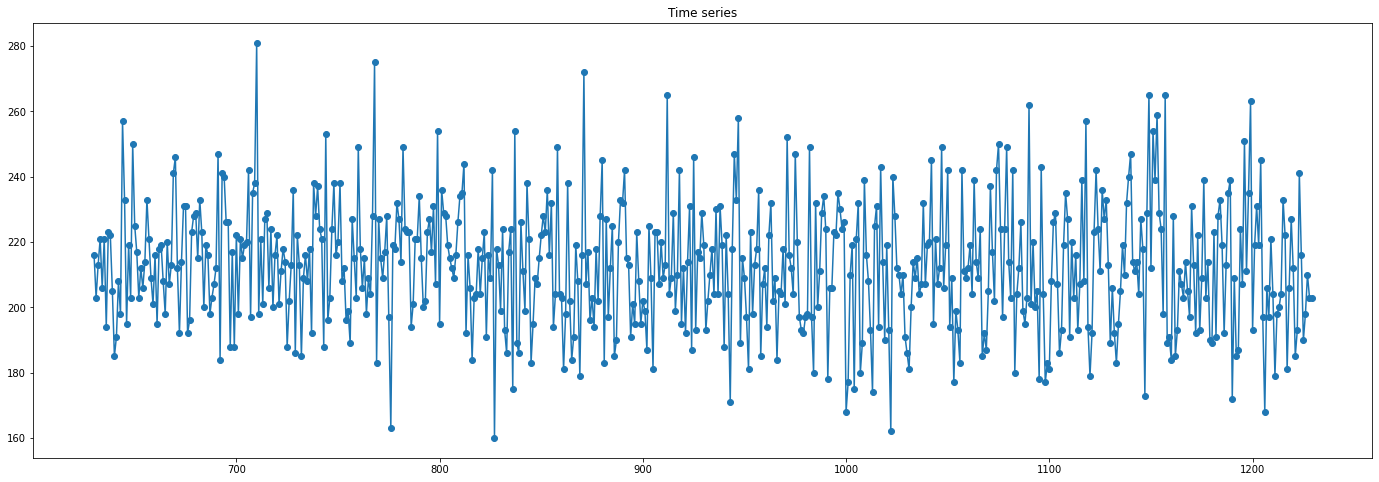

In [8]:
plt.figure(figsize=(24, 8))
plt.plot(data,marker='o')
plt.title("Time series")

The graph indicates that there is no pattern or periodicity in given series.

# 2. Exponential smoothing

In [9]:
data_train, data_test = data.iloc[:500], data.iloc[500:]

In [10]:
data_train.index = data_train.index - data_train.index[0]
    
data_test.index = data_test.index - data_test.index[0] + data_train.index[-1] +1

In [11]:
model = ExponentialSmoothing(data_train,trend='add', seasonal='add', seasonal_periods=12, damped_trend=True)

In [12]:
# fit model
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start=data_test.index[0], end=data_test.index[-1])

Text(0.5, 1.0, 'Exponential smoothing')

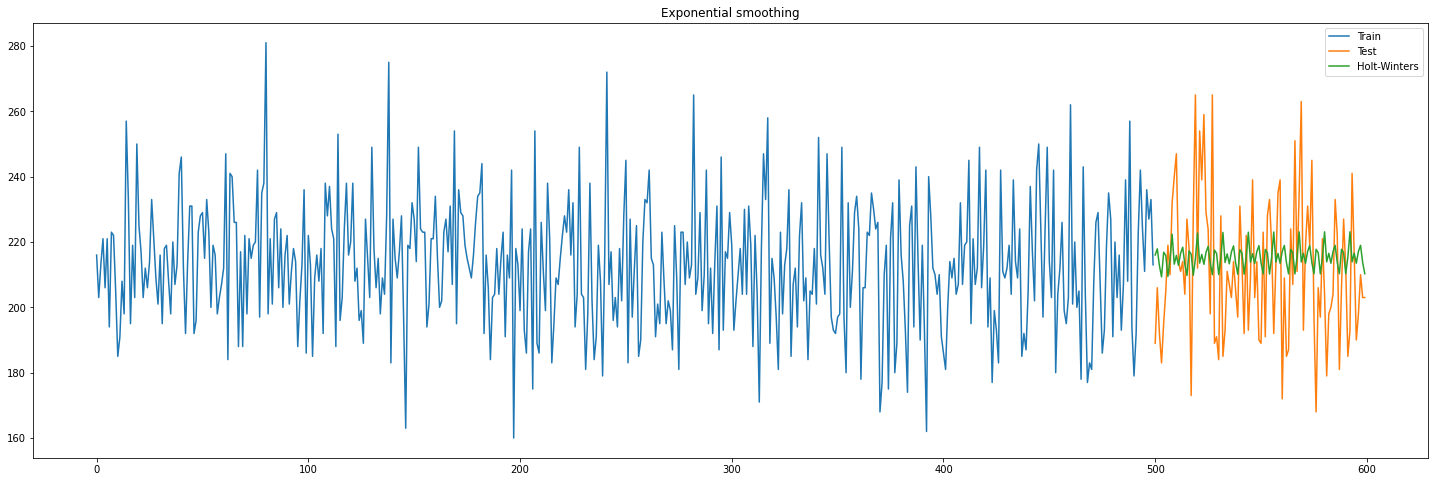

In [13]:
plt.figure(figsize=(25, 8))
plt.plot(data_train.index, data_train, label='Train')
plt.plot(data_test.index, data_test, label='Test')
plt.plot(yhat.index, yhat, label='Holt-Winters')
plt.legend(loc='best')
plt.title("Exponential smoothing")

In [14]:
def calc_errors(Y_true, Y_pred):
    mse = 0
    mae = 0
    for y_true, y_pred in zip(Y_true, Y_pred):
        mse += (y_true - y_pred)**2
        mae += abs(y_true - y_pred)
    mse = (mse/len(Y_true))**(0.5)
    mae = mae/len(Y_true)
    return mae, mse

In [15]:
mae, mse = calc_errors(data_test, yhat)
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 22.18350653392943
Mean absolute error: 18.102655320625207


The predictions are not really useful since they are not quite accurate. On avarage the predictions are around 20 points off.

# Parameter optimization

In [16]:
parameters = {'trend':['add', 'mul', None], 'seasonal' :['add', 'mul', None], 'seasonal_periods':[3,6,12,68],'damped_trend':[True, False], 'use_boxcox':[True, False],
             'smoothing_level': [0.10,0.30,0.50,0.70,0.90], 'smoothing_trend': [0.10,0.30,0.50,0.70,0.90],
             'damping_trend': [0.10,0.30,0.50,0.70,0.90]}
param_grid = list()
for t in ['add', 'mul', None]:
    for d in [True, False]:
        for s in ['add', 'mul', None]:
            for p in [12,68]:
                    for r in [True, False]:
                        #for l in [0.10,0.50,0.90]:
                            #for o in [0.10,0.50,0.90]:
                                #for m in [0.10,0.50,0.90]:
                        param_grid.append([t,d,s,p,r])
                                    
                                    
table_exp = pd.DataFrame(columns=['trend', 'seasonal', 'seasonal_periods', 'damped_trend','error'])         

for params in param_grid:
    try:  
        t,d,s,p,r = params
        
        model = ExponentialSmoothing(data_test, trend=t, damped_trend = d, seasonal = s, seasonal_periods = p)
        model_fit = model.fit(optimized=True, remove_bias=r)
        yhat = model_fit.predict(start=data_test.index[0], end=data_test.index[-1])
        mae, mse = calc_errors(data_test, yhat)
        if mae is not None:
            table_exp = table_exp.append({'trend':t,'seasonal':s,'seasonal_periods':p,'damped_trend':d,'error':mae}, ignore_index=True)
    except:
        print("error")
        
table_exp

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/cond

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/o

,trend,seasonal,seasonal_periods,damped_trend,error
0,add,add,12,True,18.538314
1,add,add,12,True,18.539571
2,add,mul,12,True,NaN
3,add,mul,12,True,NaN
4,add,None,12,True,17.242111
5,add,None,12,True,17.099539
6,add,None,68,True,17.242111
7,add,None,68,True,17.099539
8,add,add,12,False,46.351601
9,add,add,12,False,46.362423


In [17]:
table_exp.sort_values(by=['error']).head(1)

,trend,seasonal,seasonal_periods,damped_trend,error
5,add,None,12,True,17.099539


In [18]:
predictions = list()
data_t = list(data_train)

for i in range(len(data_train), len(data_train)+len(data_test)):
    model = ExponentialSmoothing(data_t, trend=t, damped_trend = d, seasonal = s, seasonal_periods = p)
    model_fit = model.fit(optimized=True, remove_bias=r)
    yhat = model_fit.predict(len(data_t), len(data_t))
    predictions.append(yhat)
    data_t.append(data_test[i])
mae, mse = calc_errors(data_test, predictions)

In [19]:
print(mae, mse)

[17.2558997] [21.37462416]


# 3. ARIMA

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

In [21]:
def arima_optim(p,q,d, seasonality= None, graph=False, title=None):
    if seasonality is None:
        model = ARIMA(data_train, order=(p,q,d))
    else:
        model = ARIMA(data_train, order=(p,q,d), seasonal_order = list([p,q,d,seasonality]))
    model_fit = model.fit()
    yhat = model_fit.predict(start=data_test.index[0], end=data_test.index[-1], alpha = 0.05)
    
    if graph:
        print(model_fit.conf_int(alpha=0.5))
        plt.figure(figsize=(20, 8))
        plt.plot(data_train.index, data_train, label='Train')
        plt.plot(data_test.index, data_test, label='Test')
        plt.plot(yhat.index, yhat, label='ARIMA')
        plt.legend(loc='best')
        plt.title(title)
    return yhat

                 0           1
const   212.322390  213.481600
sigma2  346.419709  376.029319


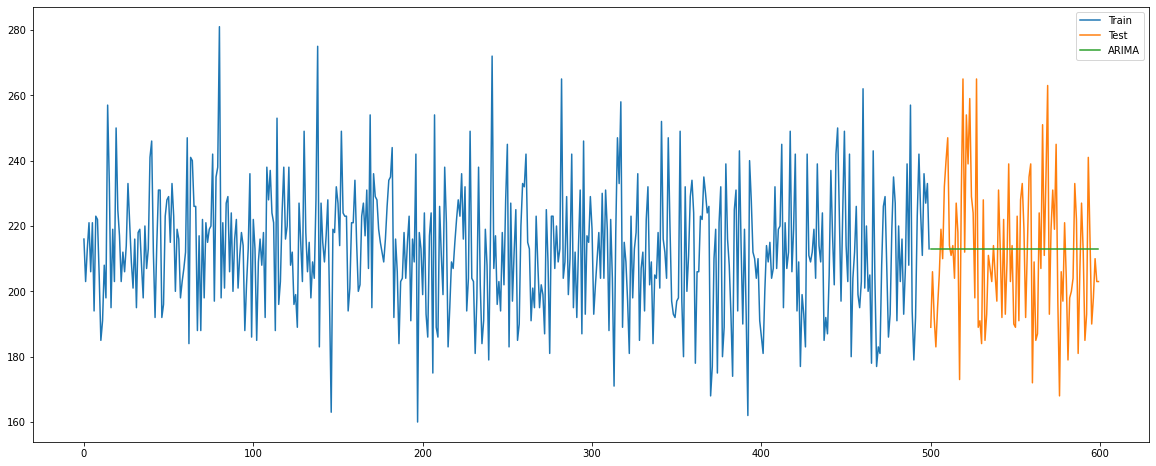

In [22]:
yhat = arima_optim(0,0,0, graph=True)

In [23]:
mae, mse = calc_errors(data_test, yhat)
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 21.36564233829179
Mean absolute error: 17.278239412685096


# Parameter optimization: p

Param p: 0
Mean absolute error: 17.278239412685096
Param p: 1
Mean absolute error: 17.278225796013565
Param p: 2
Mean absolute error: 17.26975393374712
Param p: 3
Mean absolute error: 17.2734402165162
Param p: 7
Mean absolute error: 17.204834688741343
Param p: 8
Mean absolute error: 17.19968657122414
Param p: 9
Mean absolute error: 17.21112677875313
Param p: 10
Mean absolute error: 17.213154708203337
                 0           1
const   212.391319  213.393618
ar.L1    -0.041150    0.019471
ar.L2    -0.078741   -0.014058
ar.L3    -0.025895    0.039183
ar.L4    -0.094008   -0.033585
ar.L5    -0.068780   -0.007062
ar.L6    -0.020777    0.043107
ar.L7    -0.055813    0.007709
ar.L8    -0.035024    0.023159
sigma2  343.466339  373.058414


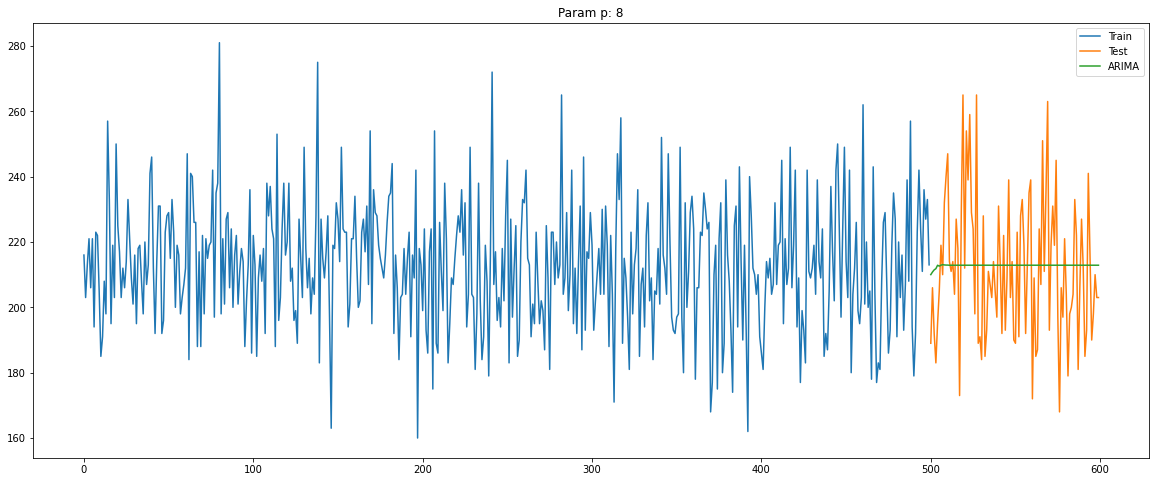

In [24]:
ps = [0,1,2,3,7,8,9,10]
optim_p = 0
min_error = math.inf

for p in ps:
    print("Param p: "+ str(p))
    yhat = arima_optim(p,0,0,graph = False)
    error = calc_errors(data_test, yhat)[0]
    print("Mean absolute error: "+ str(error))
    if error < min_error:
        min_error = error
        optim_p = p
        
yhat = arima_optim(optim_p,0,0,graph = True, title="Param p: "+str(optim_p))

smallest error for **p = 8**

# Parameter optimization: q

Param q: 0
Mean absolute error: 17.278239412685096
Param q: 1
Mean absolute error: 17.29
Param q: 2
Mean absolute error: 1008.8099999998785
Param q: 3
Mean absolute error: 45650.73000000385
Param q: 7
Mean absolute error: 109977536978.51682
                 0           1
const   212.322390  213.481600
sigma2  346.419709  376.029319


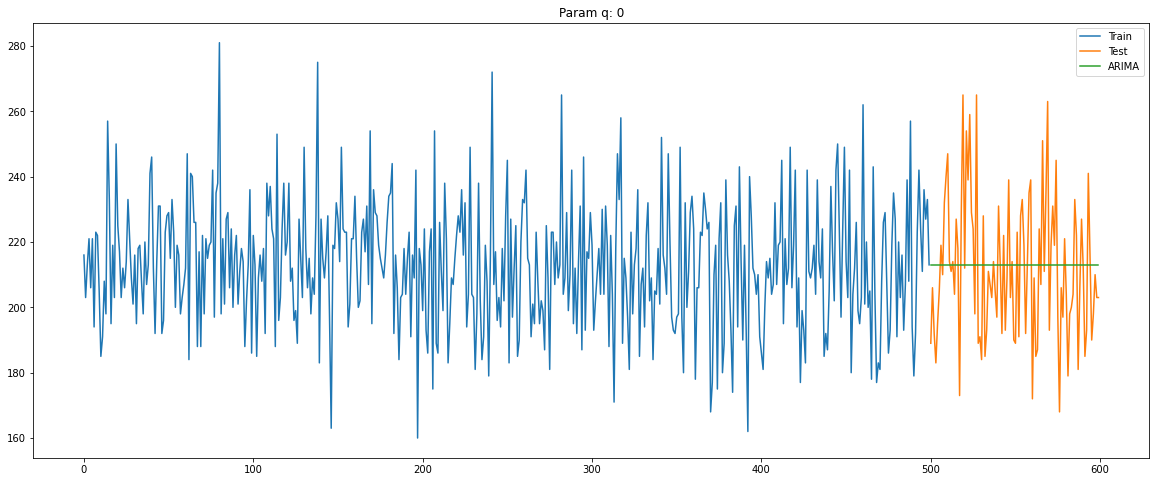

In [25]:
qs = [0,1,2,3,7]
optim_q = 0
min_error = math.inf

for q in qs:
    print("Param q: "+ str(q))
    yhat = arima_optim(0,q,0,graph = False)
    error = calc_errors(data_test, yhat)[0]
    print("Mean absolute error: "+ str(error))
    if error < min_error:
        min_error = error
        optim_q = q
        
yhat = arima_optim(0,optim_q,0,graph = True, title="Param q: "+str(optim_q))

smallest error for **q = 0**

# Parameter optimization: d

Param d: 0
Mean absolute error: 17.278239412685096
Param d: 1
Mean absolute error: 17.27819921443597
Param d: 2
Mean absolute error: 17.266857399788787
Param d: 3
Mean absolute error: 17.269733857240414
Param d: 7
Mean absolute error: 17.211120940647447
Param d: 8
Mean absolute error: 17.208302173551175
Param d: 9
Mean absolute error: 17.218907974482658
                 0           1
const   212.390526  213.395238
ma.L1    -0.040994    0.019572
ma.L2    -0.078195   -0.013527
ma.L3    -0.025177    0.040214
ma.L4    -0.089012   -0.027602
ma.L5    -0.069016   -0.006937
ma.L6    -0.014701    0.049377
ma.L7    -0.042477    0.022194
ma.L8    -0.035083    0.023887
sigma2  343.637087  373.250646


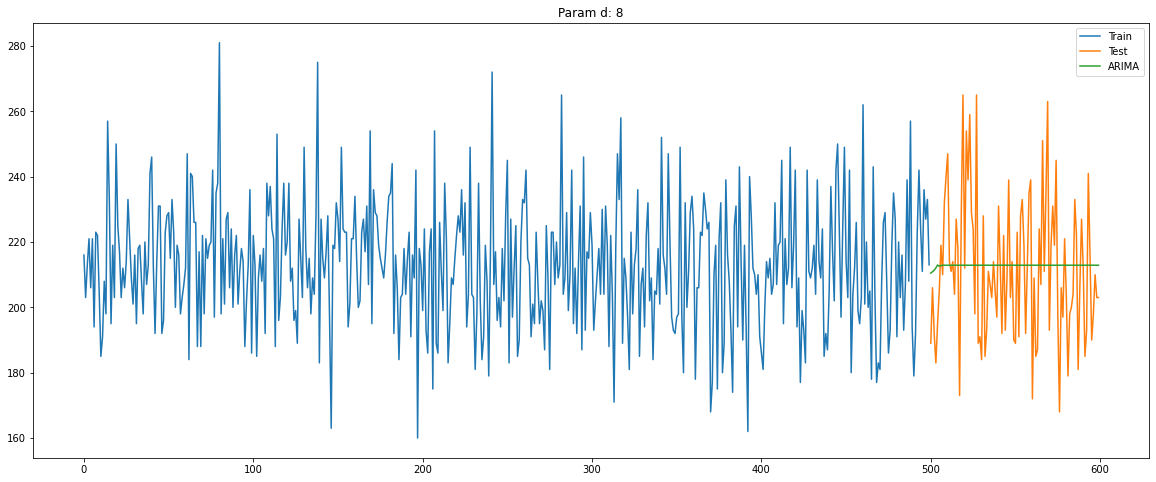

In [26]:
ds = [0,1,2,3,7,8,9]
optim_d = 0
min_error = math.inf

for d in ds:
    print("Param d: "+ str(d))
    yhat = arima_optim(0,0,d,graph = False)
    error = calc_errors(data_test, yhat)[0]
    print("Mean absolute error: "+ str(error))
    if error < min_error:
        min_error = error
        optim_d = d
        
yhat = arima_optim(0,0,optim_d,graph = True, title="Param d: "+str(optim_d))

smallest error for **d=8**

# Parameter optimization: p,q,d

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sta

error


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/

                 0           1
ar.L1    -3.288495   -3.011999
ar.L2    -5.961145   -5.090879
ar.L3    -7.388643   -5.977561
ar.L4    -6.237873   -4.726271
ar.L5    -3.774064   -2.632376
ar.L6    -1.467436   -0.839407
ar.L7    -0.295859   -0.029720
ar.L8    -0.098895   -0.017105
ma.L1     1.008666    1.318448
ma.L2    -0.054407    0.415465
ma.L3    -1.488143   -1.033637
ma.L4    -2.682135   -2.096513
ma.L5    -1.315622   -0.760501
ma.L6     0.111875    0.564150
ma.L7     0.871792    1.333652
ma.L8     0.770400    1.042870
sigma2  333.162233  391.735108


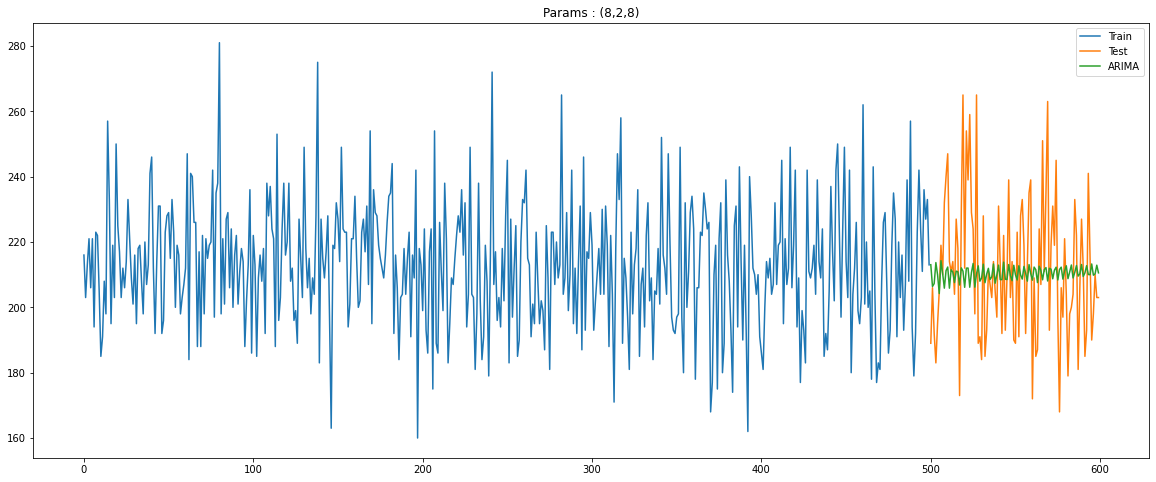

In [27]:
ps = [1,2,3,8,9]
qs = [1,2,3,7]
ds = [1,2,3,8,9]

optim_p = 0
optim_q = 0
optim_d = 0
min_error = math.inf

table_arima = pd.DataFrame(columns=['p', 'q', 'd', 'error'])         

for p in ps:
    for q in qs:
        for d in ds:
            try:
                yhat = arima_optim(p,q,d,graph = False)
                error = calc_errors(data_test, yhat)[0]
                if error < min_error:
                    min_error = error
                    optim_p = p
                    optim_q = q
                    optim_d = d
                table_arima = table_arima.append({'p':p,'q':q,'d':d,'error': error}, ignore_index=True)
            except:
                print("error")
                
table_arima

yhat = arima_optim(optim_p,optim_q,optim_d,graph = True, title="Params : ("+ str(optim_p)+","+ str(optim_q)+","+str(optim_d)+")")

In [28]:
print(min_error)

16.73472501441812


Minimalna pogreška od 16.734 se postiže za (p,q,d) = (8,2,8).

# Parameter optimization: seasonality

Param s: 2
Mean absolute error: 17.23328379431889
Param s: 3
Mean absolute error: 17.27448372641758
Param s: 5
Mean absolute error: 17.246115468512386
Param s: 7
Mean absolute error: 17.211693120849436
Param s: 9
Mean absolute error: 17.24080533235066
Param s: 12
Mean absolute error: 17.27193934500559
                  0           1
const    212.270747  213.550475
ar.L1      0.536033    1.023002
ma.L1     -1.040402   -0.584083
ar.S.L7    0.873637    1.069561
ma.S.L7   -1.070743   -0.857556
sigma2   345.194107  374.900125


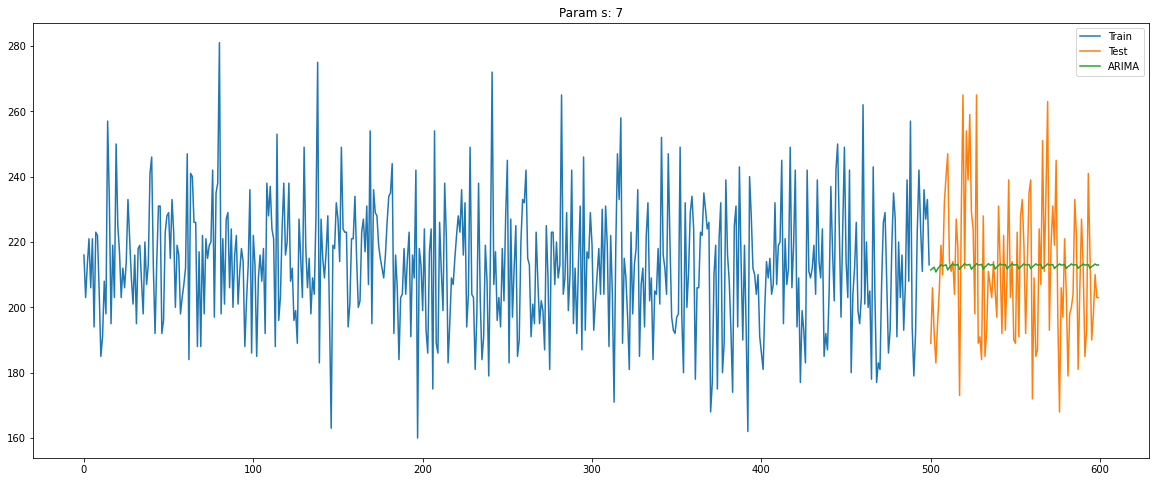

In [29]:
ss = [2,3,5,7,9,12]

optim_s = 0
min_error = math.inf

for s in ss:
    print("Param s: "+ str(s))
    yhat = arima_optim(1,0,1,seasonality = s,graph = False)
    error = calc_errors(data_test, yhat)[0]
    print("Mean absolute error: "+ str(error))
    if error < min_error:
        min_error = error
        optim_s = s
        
yhat = arima_optim(1,0,1,seasonality=optim_s,graph = True, title="Param s: "+str(optim_s))

# 4. Facebook prophet

In [30]:
pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9434303 sha256=98d6ac1252b273be3d4ebefc5cafd78bdc2c8a5fbc8ba0198a7f65ad5eacd607
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [31]:
from fbprophet import Prophet
import datetime
from datetime import datetime, timedelta

data prep

In [32]:
dataframe_train = pd.DataFrame(columns=['ds', 'y'])
dataframe_test = pd.DataFrame(columns=['ds'])
timespan = (datetime(2018,6,14,16,0,0) + timedelta(minutes=480)*x for x in range(1,601))

for row in data_train:
    dataframe_train = dataframe_train.append({'ds':next(timespan), 'y': row}, ignore_index=True)
for row in data_test:
    dataframe_test = dataframe_test.append({'ds':next(timespan)}, ignore_index=True)

In [33]:
dataframe_test

,ds
0,2018-11-28 16:00:00
1,2018-11-29 00:00:00
2,2018-11-29 08:00:00
3,2018-11-29 16:00:00
4,2018-11-30 00:00:00
...,...
95,2018-12-30 08:00:00
96,2018-12-30 16:00:00
97,2018-12-31 00:00:00
98,2018-12-31 08:00:00


model train

In [34]:
model = Prophet()
model_fit = model.fit(dataframe_train)

Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1104.41    4.7637e-05       75.5132   6.081e-07       0.001      134  LS failed, Hessian reset 
      99       1104.42    2.6694e-07       80.3625      0.3102           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1104.42   9.03559e-06       81.1227   1.324e-07       0.001      236  LS failed, Hessian reset 
     163       1104.42   1.86136e-07       78.8544      0.3816           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


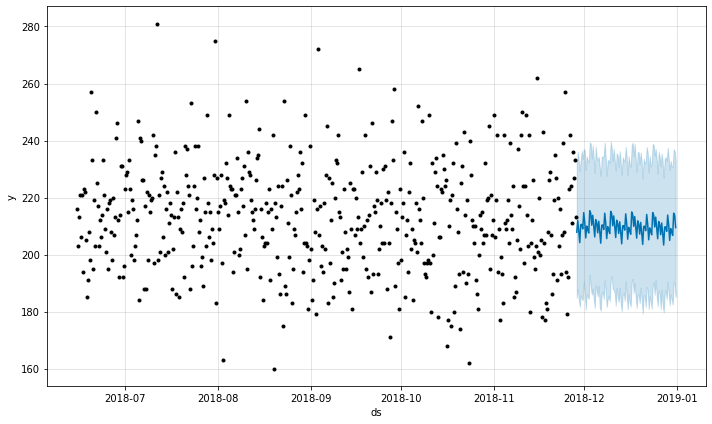

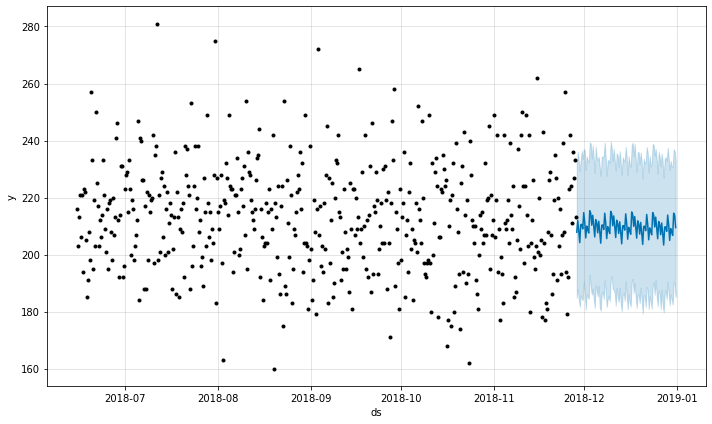

In [35]:
forecast = model_fit.predict(dataframe_test)
model_fit.plot(forecast)

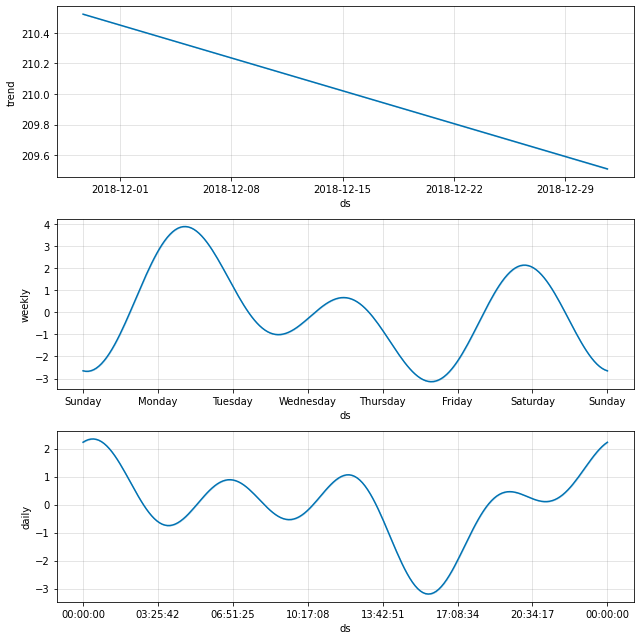

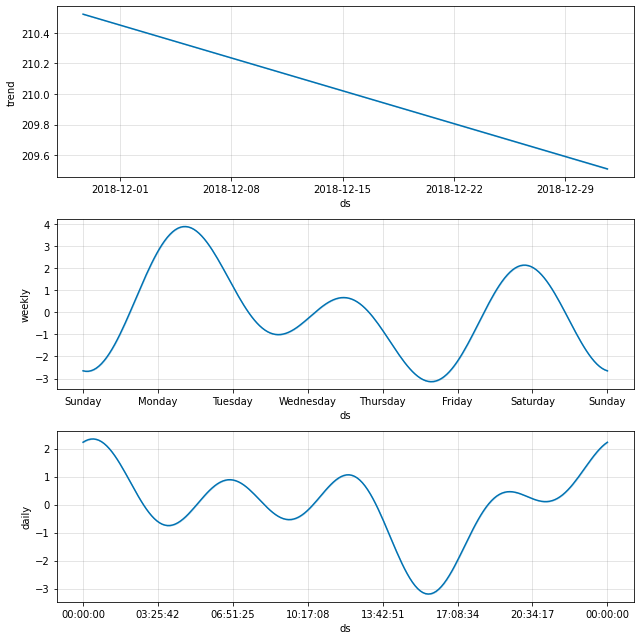

In [36]:
model_fit.plot_components(forecast)

In [37]:
mae, mse = calc_errors(data_test, forecast['yhat'])
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 21.81770792153875
Mean absolute error: 17.40658372220205


In [38]:
table_fb = pd.DataFrame(columns=['seasonality_mode', 'period','fuorier_order','error']) 
optim_s = 0
optim_p = 0
optim_period = 0
optim_f = 0
min_error = math.inf

for s in ['additive', 'multiplicative']:
    for p, period in zip(['daily', 'weekly', 'monthly', 'yearly'],[1,7,30.5,365]):
        for f in [1, 2, 3, 4, 5, 6]:
            model = Prophet(seasonality_mode=s)
            model.add_seasonality(name=p, period = period, fourier_order=f)
            model_fit = model.fit(dataframe_train)
            forecast = model_fit.predict(dataframe_test)
            mae, mse = calc_errors(data_test, forecast['yhat'])
            if mae < min_error:
                optim_s = s
                optim_p = p
                optim_period = period
                optim_f = f
            table_fb = table_fb.append({'seasonality_mode':s,'period':p,'fuorier_order':f,'error': mae}, ignore_index=True)

Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       1104.43   8.20641e-06       67.2502   1.183e-07       0.001      158  LS failed, Hessian reset 
      92       1104.44   4.75687e-08       59.6199      0.2181           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       1104.43   5.01465e-08       71.9726      0.2334           1      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1104.43   1.62683e-07       77.1934      0.3992      0.3992      137   
    Iter      log

In [39]:
model = Prophet(seasonality_mode=optim_s)
model.add_seasonality(name=optim_p, period = optim_period, fourier_order=optim_f)
model_fit = model.fit(dataframe_train)
forecast = model_fit.predict(dataframe_test)

Initial log joint probability = -3.15777
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1106.4   5.78643e-08       101.474           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        1106.4   5.24876e-08       99.6179           1           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


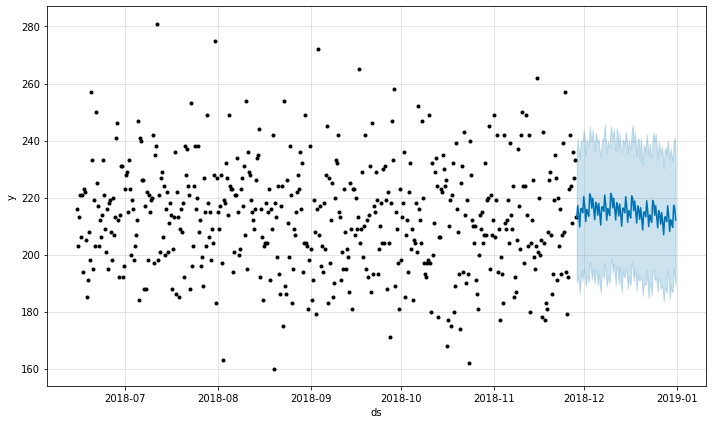

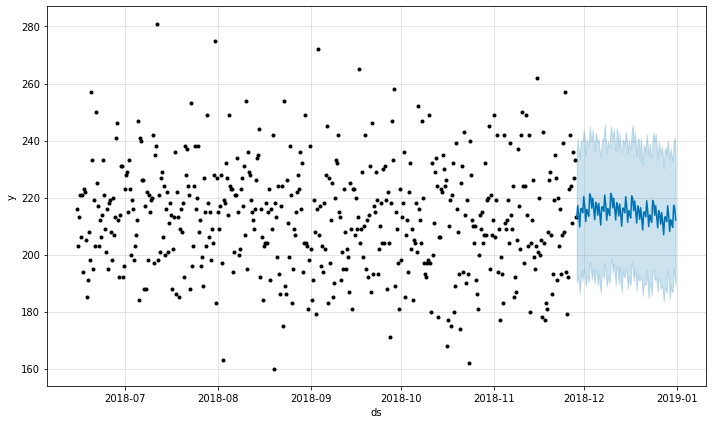

In [40]:
model_fit.plot(forecast)

In [41]:
mae, mse = calc_errors(data_test, forecast['yhat'])
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 21.836941067073276
Mean absolute error: 18.007913048486856


In [42]:
table_fb

,seasonality_mode,period,fuorier_order,error
0,additive,daily,1,17.406892
1,additive,daily,2,17.407908
2,additive,daily,3,17.403822
3,additive,daily,4,17.402583
4,additive,daily,5,17.408430
5,additive,daily,6,17.404458
6,additive,weekly,1,17.048022
7,additive,weekly,2,17.102680
8,additive,weekly,3,17.406584
9,additive,weekly,4,17.401889


# 5. RandomForestRegressor

dataset prep

In [43]:
import copy
from sklearn.ensemble import RandomForestRegressor

In [44]:
data = pd.read_csv("/kaggle/input/dapprojekt22/train.csv")
data_test = pd.read_csv("/kaggle/input/dapprojekt22/test.csv")

In [45]:
data_tmp = data.tail(600)
rfr_dataset = copy.deepcopy(data_tmp[['TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY', 'OFF_RATING_HOME', 'OFF_RATING_AWAY', 'DEF_RATING_HOME', 'DEF_RATING_AWAY', 'NEXT_HOME', 'NEXT_AWAY']])
rfr_Xtrain = rfr_dataset.head(500)
rfr_Xtest = rfr_dataset.tail(100)
rfr_ytrain = data_tmp['NEXT_WINNER'].head(500)
rfr_ytest = data_tmp['NEXT_WINNER'].tail(100)

In [46]:
def data_transform(dataset):
    new_dataset = pd.DataFrame(columns=['OFF_RATING_HOME','OFF_RATING_AWAY','DEF_RATING_HOME','DEF_RATING_AWAY'])
    for i,row in dataset.iterrows():
        next_home = row["NEXT_HOME"]
        next_away = row["NEXT_AWAY"]
        
        values = []
        
        for team in [next_home, next_away]:
        
            home = dataset.loc[(dataset.TEAM_ABBREVIATION_HOME == team)]
            away = dataset.loc[(dataset.TEAM_ABBREVIATION_AWAY == team)]

            values.append((home['OFF_RATING_HOME'].mean() + away['OFF_RATING_AWAY'].mean())*0.5)
            values.append((home['DEF_RATING_HOME'].mean() + away['DEF_RATING_AWAY'].mean())*0.5)
            
        new_dataset = new_dataset.append({'OFF_RATING_HOME': values[0], 'OFF_RATING_AWAY': values[2], 'DEF_RATING_HOME': values[1],'DEF_RATING_AWAY': values[3]},ignore_index=True)
        
    return new_dataset

In [47]:
rbr_Xtrain = data_transform(rfr_Xtrain)
rbr_Xtest = data_transform(rfr_Xtest)

In [48]:
rbf = RandomForestRegressor(max_depth=2, random_state=0)
rbf.fit(rbr_Xtrain, rfr_ytrain)
y = rbf.predict(rbr_Xtest)

In [49]:
calc_errors(rfr_ytest, y)

(0.40662082072611566, 0.44181885432892)

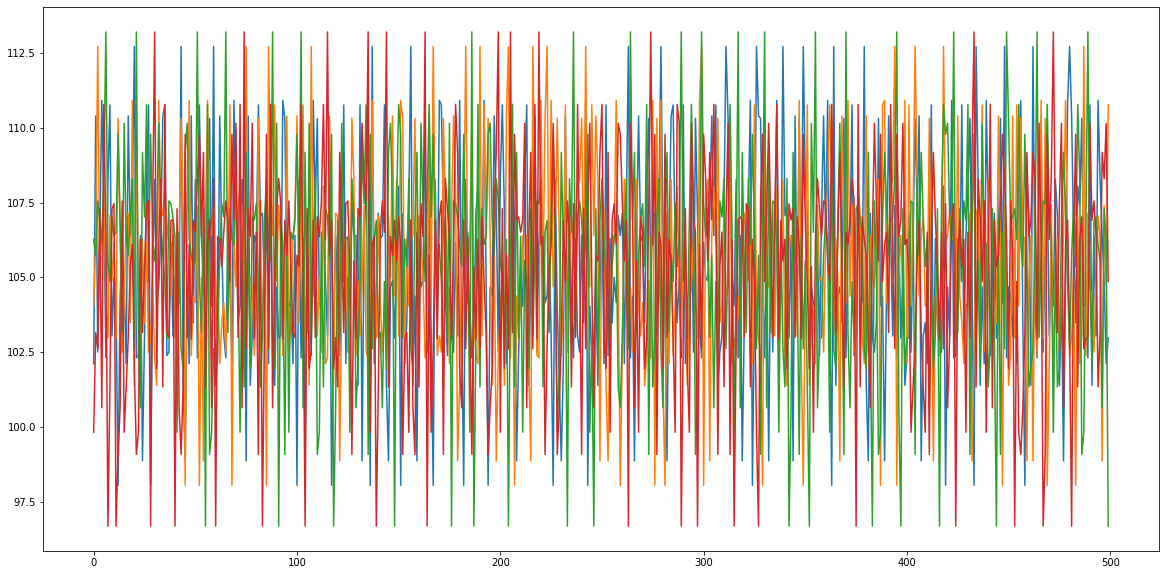

In [50]:
plt.figure(figsize=(20, 10)) 
plt.plot(rbr_Xtrain) 
plt.show()

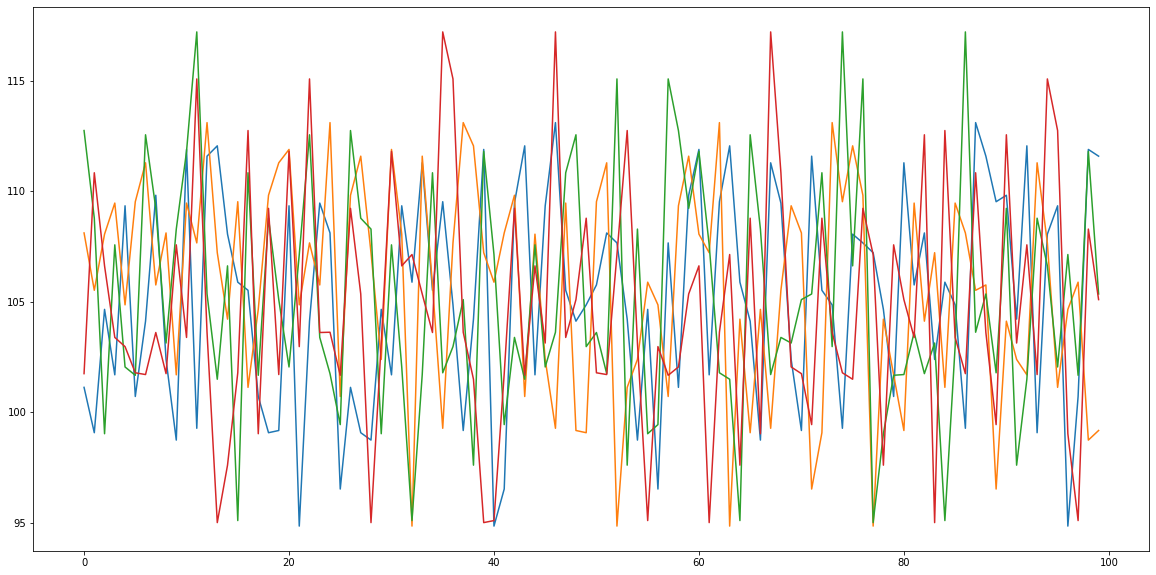

In [51]:
plt.figure(figsize=(20, 10)) 
plt.plot(rbr_Xtest) 
plt.show()

# 6. Generated signal

In [52]:
from scipy import signal

In [53]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 200 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(134*np.pi)
trend1 = np.linspace(0, 100, 100)/(104*np.pi)
trend2 = np.linspace(0, 300, 300)/(-122*np.pi)
trend3 = np.linspace(0, 200, 200)/(111*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

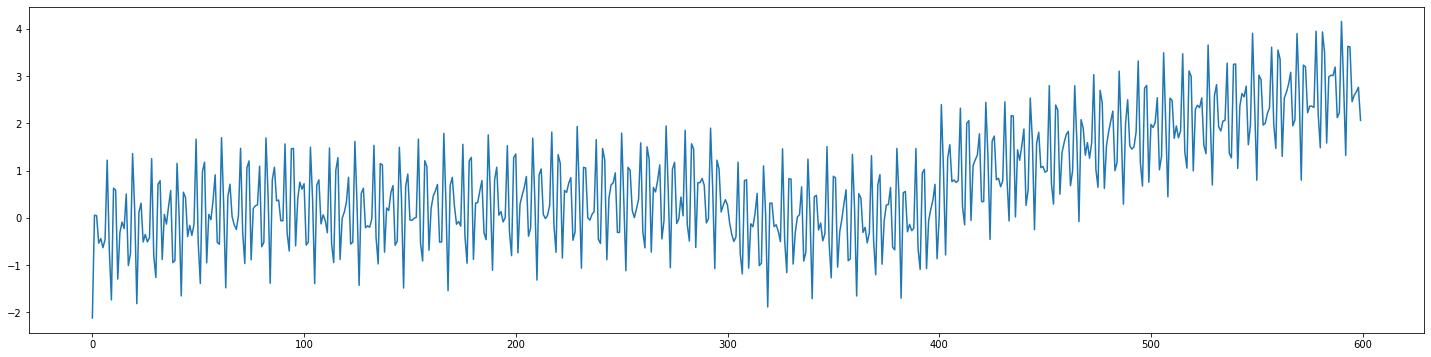

In [54]:
plt.figure(figsize=(25, 6)) 
plt.plot(pts)

# Exponential smoothing

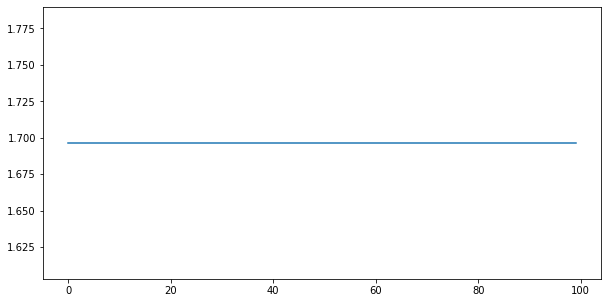

In [55]:
model = ExponentialSmoothing(pts_train)
# fit model
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(100)
plt.figure(figsize=(10, 5))
plt.plot(yhat) 

In [56]:
mae, mse = calc_errors(pts_test, yhat)
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 1.069565729310348
Mean absolute error: 0.8822039586868771


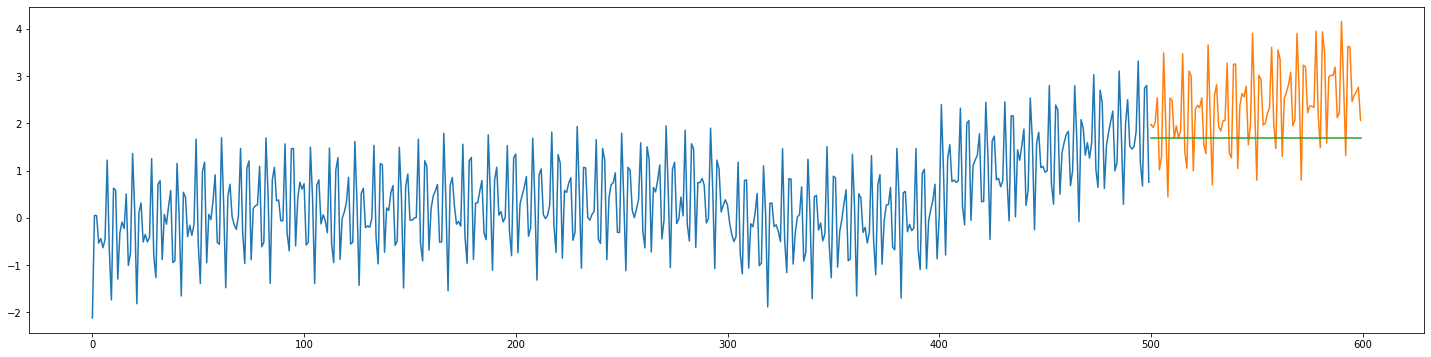

In [57]:
plt.figure(figsize=(25, 6))
plt.plot(pts_train)
plt.plot(pd.DataFrame(pts_test, columns=['PTS'], index = [x for x in range(500, 600)])) 
plt.plot(pd.DataFrame(yhat, columns=['PTS'], index = [x for x in range(500, 600)]))

# ARIMA

In [58]:
model = ARIMA(pts_train, order=(1, 0, 1))
fit_model = model.fit()
prediction = fit_model.predict(start=500,end=599)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


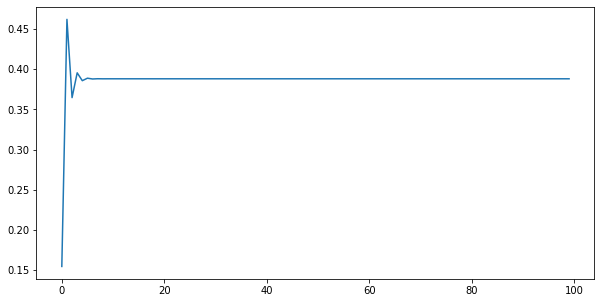

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(prediction)
plt.show()

In [60]:
mae, mse = calc_errors(pts_test, yhat)
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 1.069565729310348
Mean absolute error: 0.8822039586868771


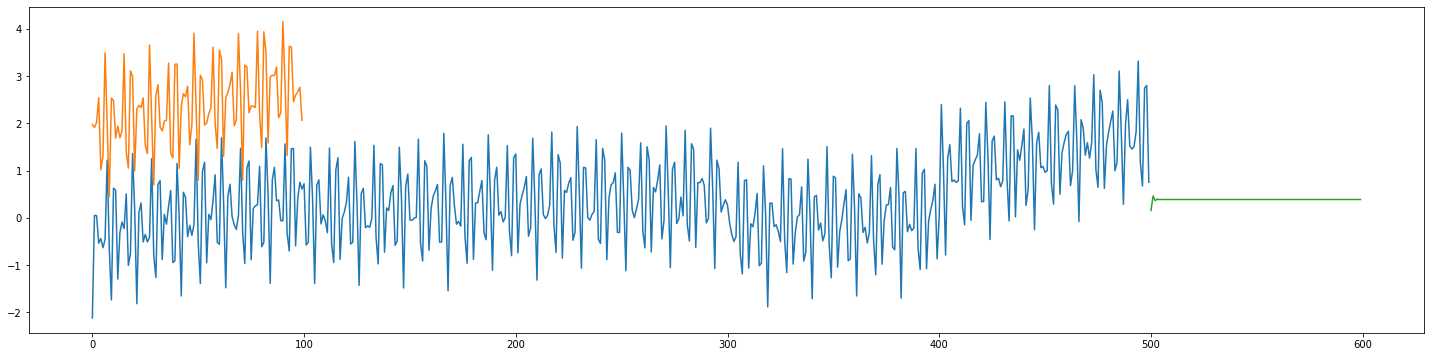

In [61]:
prediction = pd.DataFrame(prediction, index=[i for i in range(500, 600)])
plt.figure(figsize=(25, 6))
plt.plot(pts_train)
plt.plot(pts_test)
plt.plot(prediction)

# Prophet

In [62]:
dataframe_train = pd.DataFrame(columns=['ds', 'y'])
dataframe_test = pd.DataFrame(columns=['ds'])
timespan = (datetime(2018,6,14,16,0,0) + timedelta(minutes=480)*x for x in range(1,601))

for row in pts_train:
    dataframe_train = dataframe_train.append({'ds':next(timespan), 'y': row}, ignore_index=True)
for i in range (100):
    dataframe_test = dataframe_test.append({'ds':next(timespan)}, ignore_index=True)

In [63]:
model = Prophet()
model_fit = model.fit(dataframe_train)

Initial log joint probability = -51.5232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.684   4.55041e-07       84.0979      0.4042       0.231      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       439.684   2.67922e-09       83.6786      0.1777      0.1777      148   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


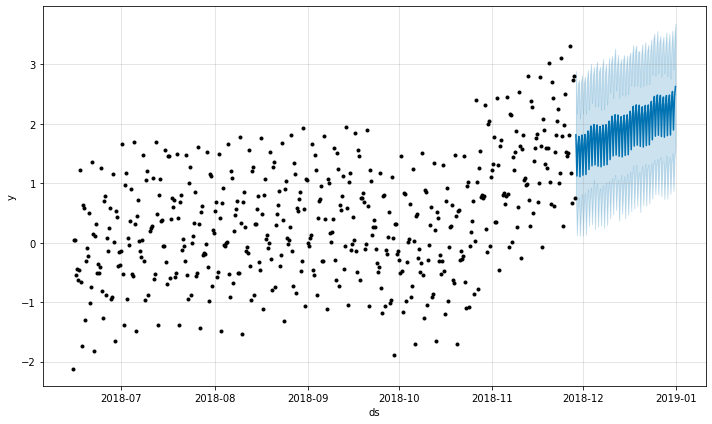

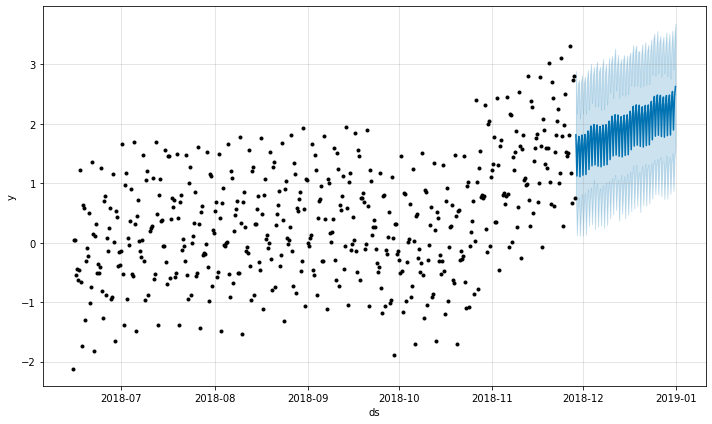

In [64]:
forecast = model_fit.predict(dataframe_test)
model_fit.plot(forecast)

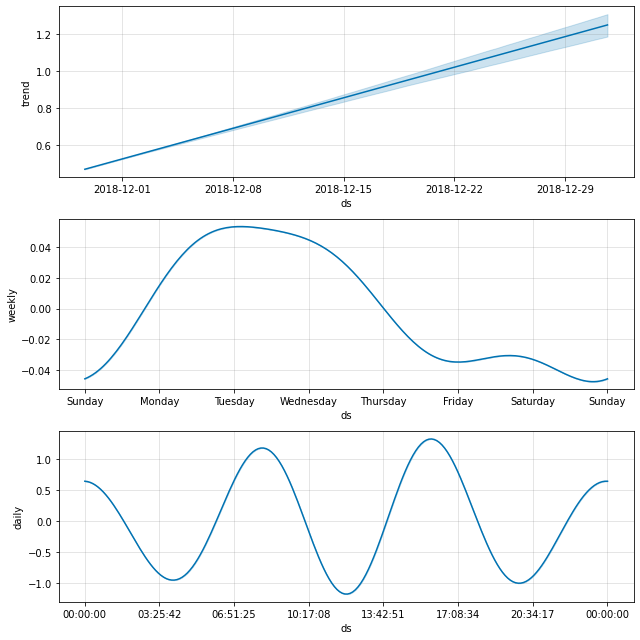

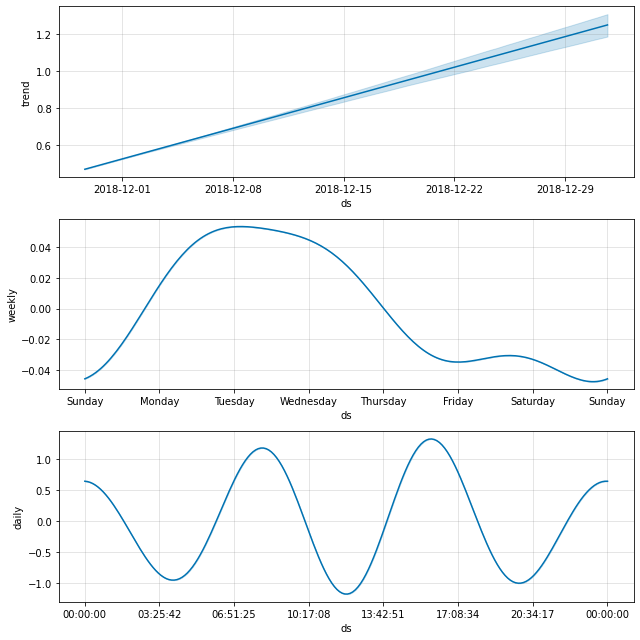

In [65]:
model_fit.plot_components(forecast)

In [66]:
mae, mse = calc_errors(pts_test, forecast['yhat'])
print("Mean square error: "+ str(mse))
print("Mean absolute error: "+ str(mae))

Mean square error: 0.9258827358452749
Mean absolute error: 0.7591062331095455
